In [1]:
import math
import time
import gc
import os
import re


import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.animation import FuncAnimation, PillowWriter


In [2]:
gc.collect()

#assert torch.cuda.is_available(), "Should use GPU-enabled colab"

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [3]:
print(torch.cuda.is_available())

False


In [4]:
def isolated_plot_grid(x):
    plt.figure(figsize=(10, 10))
    plt.imshow(x[0, 0].cpu().detach().numpy(), cmap='viridis')
    plt.colorbar()
    plt.title('Grids')
    plt.show()

In [5]:
# class GridCell(nn.Module):
#     def __init__(self, kernel_size):
#         super(GridCell, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=kernel_size, stride=1, padding=0, bias=False)  # Set padding to 0

#     def custom_padding(self, x, pad_size):
#         # # isolated_plot_grid(x)
#         # # print(x.shape)
#         # width = x.shape[2]
#         # x = torch.cat((x[:, :, :, -pad_size:], x, x[:, :, :, :pad_size]), dim=3)
#         # # isolated_plot_grid(x)
#         # # print(x.shape)
#         # x = torch.cat((torch.roll(x[:, :, -pad_size:, :], width//2 ,3), x, torch.roll(x[:, :, :pad_size, :], width//2 ,3)), dim=2)
#         # # isolated_plot_grid(x)
#         # # print(x.shape)
#         # return x
    
#         x = torch.cat((x[:, :, :, -pad_size:], x, x[:, :, :, :pad_size]), dim=3)
#         x = torch.cat((x[:, :, -pad_size:, :], x, x[:, :, :pad_size, :]), dim=2)
#         return x


#     def forward(self, x):
#         pad_size = self.conv1.kernel_size[0] // 2
#         x = self.custom_padding(x, pad_size)
#         x = self.conv1(x)
#         return x

# # Instantiate the model
# model = GridCell(kernel_size).to(device)
# print(model)

In [6]:
kernel_size = 128

In [7]:
class GridCell(nn.Module):
    def __init__(self, kernel_size):
        super(GridCell, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=kernel_size, stride=1, padding=kernel_size//2, bias=False, padding_mode="circular")  # Set padding to 0



    def forward(self, x):
        x = self.conv1(x)
        return x

# Instantiate the model
model = GridCell(kernel_size).to(device)
print(model)

GridCell(
  (conv1): Conv2d(1, 1, kernel_size=(128, 128), stride=(1, 1), padding=(64, 64), bias=False, padding_mode=circular)
)


In [8]:
def gaussian(x, mu, sigma):
    return (1 / (sigma * (2 * np.pi)**0.5)) * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

def center_surround(distance, width):
    factor = (3 * np.pi) / 2
    return np.cos((distance / width) * factor) * gaussian((distance / width) * factor, 0, 2.9)
    # return (np.exp(-((distance*(2/width)) ** 2)) -0.25) * 2

def make_filter(size):
    x = torch.zeros_like(model.conv1.weight)
    center = (size - 1) / 2
    
    # print(((center - center) ** 2 + (j - center) ** 2) ** 0.5)
    for i in range(size):
        for j in range(size):
            dist_from_center = ((i - center) ** 2 + (j - center) ** 2) ** 0.5
            x[0, 0, i, j] = center_surround(dist_from_center, center)
    mean = torch.mean(x)
    x = x - mean
    return x



In [9]:
# def W_0(x):
#     a = 1
#     lambda_net = 13
#     beta = 3 / lambda_net ** 2
#     gamma = 1.05 * beta

#     mag_x = np.linalg.norm(x)

#     return a * np.exp(-gamma * mag_x ** 2) - np.exp(-beta * mag_x ** 2)

In [44]:
#for multiple inputs
def W_0(x):
    a = 1
    lambda_net = 13
    beta = 3 / lambda_net ** 2
    gamma = 1.05 * beta

    mag_x = np.linalg.norm(x, axis=1)

    return a * np.exp(-gamma * mag_x ** 2) - np.exp(-beta * mag_x ** 2)

In [59]:
def W_0(x):
    a = 1
    lambda_net = 13
    beta = 3 / lambda_net ** 2
    gamma = 1.05 * beta

    # Compute the magnitude of each vector (L2 norm)
    x = x.float()
    mag_x = torch.norm(x, dim=1)

    # Compute the weight values
    return a * torch.exp(-gamma * mag_x ** 2) - torch.exp(-beta * mag_x ** 2)

In [45]:
neural_sheet_width = 128
directions = np.array([[0, 1], [1, 0], [0, -1], [-1, 0]]) 


W = np.zeros((neural_sheet_width ** 2, neural_sheet_width ** 2))
masks = np.zeros((4, neural_sheet_width ** 2))

# grid coordinates
grid_indices = np.arange(neural_sheet_width ** 2)
x_coords = grid_indices % neural_sheet_width
y_coords = grid_indices // neural_sheet_width
positions = np.stack([x_coords, y_coords], axis=1)
l = 0

for i in range(neural_sheet_width):
    # print(i)
    for j in range(neural_sheet_width):
        k = neural_sheet_width * i + j
        x_i = positions[k]

        direction_index = (2 * i + j) % 4
        #print(direction_index)
        current_dir = directions[direction_index] 

        masks[direction_index, k] = 1
        # print(direction_index, k)
        shifted_locs = x_i - positions - current_dir * l

        W[k, :] = W_0(shifted_locs)
    # raise


In [61]:
neural_sheet_width = 128
directions = torch.tensor([[0, 1], [1, 0], [0, -1], [-1, 0]], dtype=torch.int32)

# Initialize weights and masks
W = torch.zeros((neural_sheet_width ** 2, neural_sheet_width ** 2), dtype=torch.float32)
masks = torch.zeros((4, neural_sheet_width ** 2), dtype=torch.float32)

# Grid coordinates
grid_indices = torch.arange(neural_sheet_width ** 2, dtype=torch.int32)
x_coords = grid_indices % neural_sheet_width
y_coords = grid_indices // neural_sheet_width
positions = torch.stack([x_coords, y_coords], dim=1)

# Iterate over the grid
l = 0
for i in range(neural_sheet_width):
    for j in range(neural_sheet_width):
        k = neural_sheet_width * i + j
        x_i = positions[k]

        direction_index = (2 * i + j) % 4
        current_dir = directions[direction_index]

        masks[direction_index, k] = 1  # Set the mask for the current direction

        # Calculate shifted locations
        shifted_locs = x_i - positions - current_dir * l
        # print(shifted_locs)
        # print(type(shifted_locs))

        # Compute W[k, :] based on the shifted locations
        W[k, :] = W_0(shifted_locs)

In [12]:
# neural_sheet_width = 31
# directions = [np.array([0, 1]), np.array([1, 0]), np.array([0, -1]), np.array([-1, 0])]

# W = np.zeros((neural_sheet_width ** 2, neural_sheet_width ** 2))

# for i in range(neural_sheet_width ** 2): #inputs
#     print(i)
    
#     for j in range(neural_sheet_width ** 2): #outputs
#         x_i = np.array([i % neural_sheet_width, int(i / neural_sheet_width)])
#         x_j = np.array([j % neural_sheet_width, int(j / neural_sheet_width)])

#         #print(x_i, x_j)
#         current_dir = directions[(2 * i + j) % 4]
#         l = 0

#         shifted_loc = np.subtract(np.subtract(x_i, x_j), np.multiply(current_dir, l))

#         W[i, j] = W_0(shifted_loc) 

#W = np.subtract(W, np.mean(W))
#W = W.reshape((1, 1, neural_sheet_width, neural_sheet_width))

In [46]:
print(masks[2, :10])

[0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]


tensor(-124844.0547)


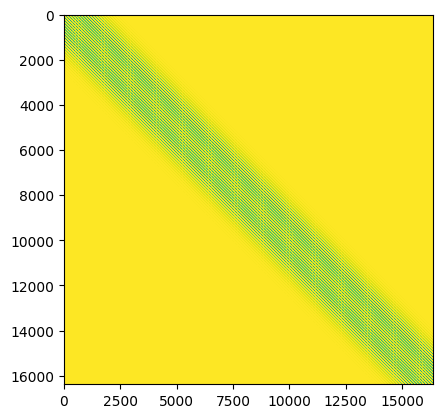

In [63]:
# Manually set the weights and biases of the conv1 layer
with torch.no_grad():
    #weights = make_filter(kernel_size).to(device)
    weights = W #torch.from_numpy(W)
    weights = weights.type(torch.FloatTensor)
    print(weights.sum())
    model.conv1.weight = nn.Parameter(weights)
    # model.conv1.bias = nn.Parameter(torch.zeros_like(model.conv1.bias))
    
#isolated_plot_grid(model.conv1.weight)
plt.imshow(W)

In [64]:
def find_peaks(x):
    peaks = []
    for i in range(1, x.shape[0] - 1):
        if x[i] > x[i - 1] and x[i] > x[i + 1]:
            peaks.append(i)
    return peaks

128


Text(0, 0.5, 'Weight')

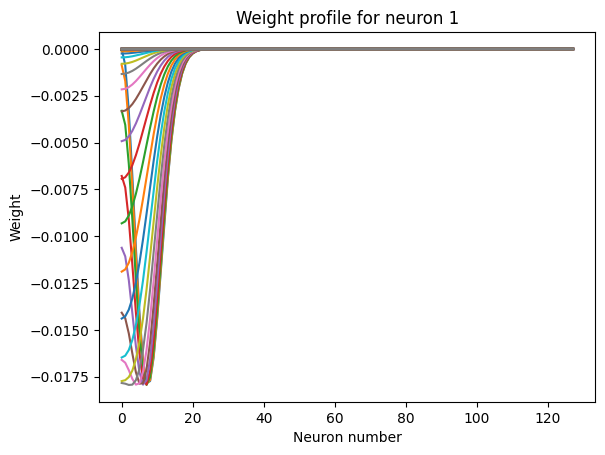

In [65]:
W_1 =  W[:1][0]
W_1 = W_1.reshape((neural_sheet_width, neural_sheet_width))
print(W_1.shape[0])
xs = np.arange(0,W_1.shape[0],1)
plt.plot(W_1)
plt.title("Weight profile for neuron 1")
plt.xlabel('Neuron number')
plt.ylabel('Weight')

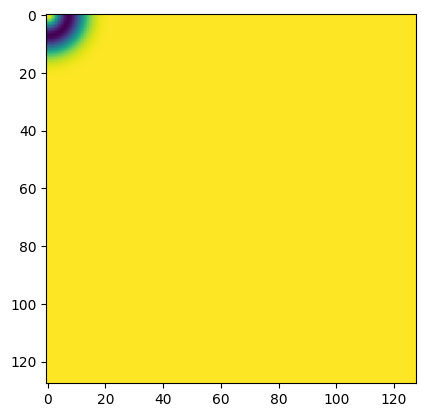

In [66]:
plt.imshow(W_1)

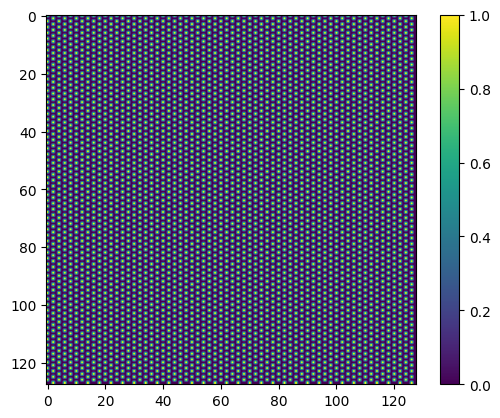

In [67]:
plt.imshow(masks[0].reshape((neural_sheet_width, neural_sheet_width)))
# plt.imshow(masks[1, :].reshape((9, 9)))
plt.colorbar()

In [57]:
def rect_lin(I):
  R = I.copy()
  R[I<0] = 0
  return R

#@title Adjust params { run: "auto" }
b = 47 #@param {type:"slider", min:1, max:50, step:1}

bs = b*np.ones(neural_sheet_width ** 2)

def input_bs(N, E, S, W):
  full_input = N * masks[0] + E * masks[1] + S * masks[2] + W * masks[3]
  return full_input

dt = .1 #ms
tau = 10 #ms
x_0 = np.random.normal(0, .1, neural_sheet_width ** 2)
t_end = 200 #ms
timesteps = np.arange(0, t_end, dt)
Xs = np.zeros([neural_sheet_width ** 2, len(timesteps, )])
Xs[:,0] = x_0
for i in range(0, len(timesteps)-1):
  x = Xs[:,i]
  I = np.dot(W, x)+input_bs(1, 0, 0, 0) + bs

# for i in range(0,len(timesteps)-1):
#   x = Xs[:,i]
#   if i > 500 and i < 1000:
#     I = np.dot(W, x)+input_bs(0.5, 0, 0, 0) + bs
#   else:
#     I = np.dot(W, x) #+input_bs(47, 47, 0, 0) #bs
  dx_dt = (1/tau)*(-x+I)
  Xs[:,i+1] = rect_lin(x +dx_dt*dt)



Text(0, 0.5, 'Synaptic activation (x)')

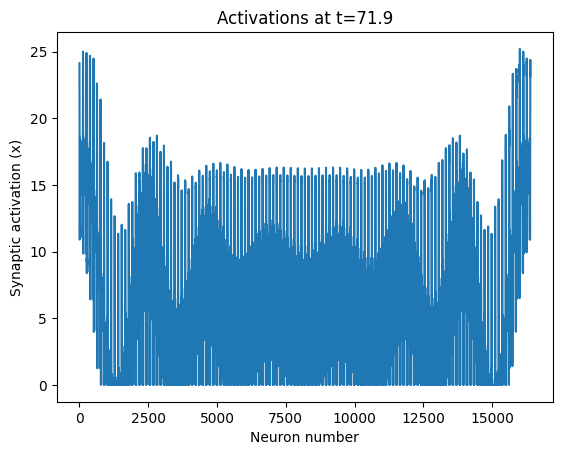

In [56]:
t = 71.9 #@param {type:"slider", min:0, max:200, step:0.1}
ind = int(t/.1)
xs = np.arange(neural_sheet_width ** 2)
plt.plot(xs, Xs[:,ind])
title_text = "Activations at t="+str(t)
plt.title(title_text)
plt.xlabel('Neuron number')
plt.ylabel('Synaptic activation (x)')

torch.Size([16384])


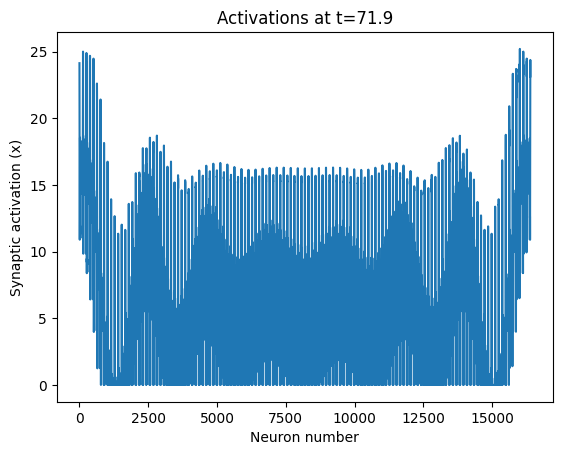

In [42]:
# Parameters
neural_sheet_width = 128  # Adjust as needed
b = 47  # Bias value
bs = b * torch.ones(neural_sheet_width ** 2)
print(bs.shape)

# Define input function
def input_bs(N, E, S, W):
    return N * masks[0] + E * masks[1] + S * masks[2] + W * masks[3]

# Simulation parameters
dt = 0.1  # ms
tau = 10  # ms
x_0 = torch.tensor(np.random.normal(0, 0.1, neural_sheet_width ** 2), dtype=torch.float32)
t_end = 200  # ms
timesteps = torch.arange(0, t_end, dt)
Xs = torch.zeros(neural_sheet_width ** 2, len(timesteps))
Xs[:, 0] = x_0

# Time iteration
for i in range(len(timesteps) - 1):
    x = Xs[:, i]
    I = torch.matmul(W, x) + input_bs(1, 0, 0, 0) + bs
    dx_dt = (1 / tau) * (-x + I)
    Xs[:, i + 1] = torch.relu(x + dx_dt * dt)

# Visualization
t = 71.9  # Example time
ind = int(t / dt)
xs = np.arange(neural_sheet_width ** 2)
plt.plot(xs, Xs[:, ind].numpy())
plt.title(f"Activations at t={t}")
plt.xlabel("Neuron number")
plt.ylabel("Synaptic activation (x)")
plt.show()

In [70]:
b = 47 #@param {type:"slider", min:1, max:50, step:1}

bs = b*torch.ones(neural_sheet_width ** 2)

def input_bs(N, E, S, W):
  full_input = N * masks[0] + E * masks[1] + S * masks[2] + W * masks[3]
  return full_input

dt = .1 #ms
tau = 10 #ms
x_0 = torch.tensor(np.random.normal(0, 0.1, neural_sheet_width ** 2), dtype=torch.float32)
t_end = 200 #ms
timesteps = torch.arange(0, t_end, dt)
Xs = torch.zeros([neural_sheet_width ** 2, len(timesteps, )])
Xs[:,0] = x_0
for i in range(0, len(timesteps)-1):
  x = Xs[:,i]
  I = torch.matmul(W, x)+input_bs(1, 0, 0, 0) + bs
  dx_dt = (1/tau)*(-x+I)
  Xs[:,i+1] = torch.relu(x +dx_dt*dt)

KeyboardInterrupt: 

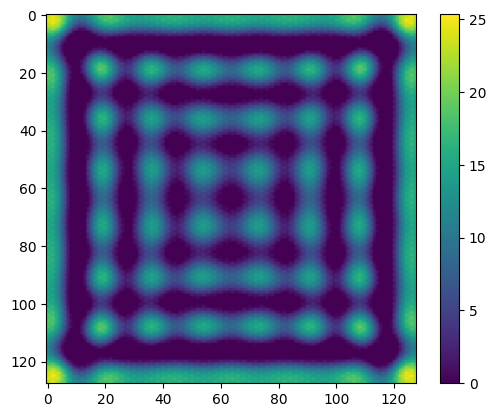

In [43]:
Xs_end = Xs[:,1900].reshape((neural_sheet_width, neural_sheet_width))

plt.imshow(Xs_end)
plt.colorbar()

In [ ]:
#Define the Ws
N =neural_sheet_width ** 2
W_l = np.zeros([N,N])
W_r = np.zeros([N,N])
delta = (2*np.pi)*(2/N)

def f_W_mn(theta):
  return np.cos(theta)-1

def theta(m):
  return (2*np.pi*m)/N

for m in range(N):
  for n in range(N):
    W_l[m,n] = f_W_mn(theta(m)-theta(n) - delta)
    W_r[m,n] = f_W_mn(theta(m)-theta(n) + delta)

print(np.size(W_1))
xs = np.arange(0,np.size(W_1),1)
plt.plot(xs, W_l[:1][0])
plt.plot(xs, W_r[:1][0])

plt.title("Weight profile for neuron 1")
plt.xlabel('Neuron number')
plt.ylabel('Weight')


In [ ]:
torch.cuda.empty_cache()
gc.collect()

portion_update = 0.09
random_factor = 0.0001

width = 128
# height = int(width * np.sqrt(3)/2)
height = 128
num_iters = 5000

# grids = torch.rand(1, 1, grid_size, grid_size).to(device) / np.sqrt(2)
# grids = torch.rand(1, 1, height, width).to(device)
grids = torch.zeros(1, 1, height, width).to(device)
# grids[0, 0, grid_size//2, grid_size//2] = 1

# model(grids)

# Forward pass
with torch.no_grad():
    for i in tqdm(range(num_iters), desc="Processing"):
        # print(grids.shape)
        
        random_deviation = torch.rand(1, 1, height, width).to(device) * random_factor
        grids = (1 - portion_update) * grids + portion_update * (model(grids) + random_deviation)
        
        
        
        grids = (1 - portion_update) * grids + portion_update * model(grids)
        
        
        # normalize
        grids = (grids - grids.min()) / (grids.max() - grids.min())
        # in grid center add some value
        # grids[0, 0, int(height* (i/num_iters)), :] = 1
        
        # deviation = int(10 * (i/num_iters))
        
        # for j in range(0, height, 20):
        #     for k in range(0, width, 20):
        #         grids[0, 0, (j + deviation)%height, (k+ deviation)% width] = 1
        
        
        if i % 1000 == 0:
            isolated_plot_grid(grids)
            slice_across = grids[0,0, height//2, :].cpu().detach().numpy()
            plt.plot(slice_across)
            print(find_peaks(slice_across))

In [11]:
def get_next_filename(directory, base_name, extension):
    files = os.listdir(directory)
    pattern = re.compile(rf"{base_name}_(\d+){extension}")
    numbers = [int(pattern.match(f).group(1)) for f in files if pattern.match(f)]
    next_number = max(numbers, default=0) + 1
    return os.path.join(directory, f"{base_name}_{next_number}{extension}")

In [12]:
def plot_grid(grids, ax):
    ax.clear()
    im = ax.imshow(grids[0, 0].cpu().detach().numpy(), cmap='viridis')
    return im

torch.cuda.empty_cache()
gc.collect()

portion_update = 0.1
random_factor = 0.0001

grid_size = 100
num_iters = 10000
num_frames = 100
num_deviation = 30

iters_per_frame = num_iters // num_frames

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# grids = torch.zeros(1, 1, grid_size, grid_size).to(device)
grids = torch.rand(1, 1, grid_size, grid_size).to(device)


fig, ax = plt.subplots(figsize=(10, 10))

progress_bar = tqdm(total=num_frames, desc="Processing frames")

def update(frame):
    global grids
    
    for i in range(iters_per_frame):
        cur_iter = (frame * iters_per_frame) + i
        
        random_deviation = torch.rand(1, 1, grid_size, grid_size).to(device) * random_factor
        grids = (1 - portion_update) * grids + portion_update * (model(grids) + random_deviation)
        grids = (grids - grids.min()) / (grids.max() - grids.min())

        # index = int((frame/num_iters) * 2)
        # grids[0, 0, (index - 1)%grid_size, :] = 0.8
        # grids[0, 0, index, :] = 1
        # grids[0, 0, (index + 1)%grid_size, :] = 0.8
        
        # grids[0, 0, (grid_size//2) - 1, :] = 0.8
        # grids[0, 0, grid_size//2, :] = 1
        # grids[0, 0, (grid_size//2) + 1, :] = 0.8
        
        deviation = int(num_deviation * (cur_iter/num_iters))
        
        for j in range(0, grid_size, 20):
            for k in range(0, grid_size, 20):
                grids[0, 0, (j + deviation)%grid_size, (k+ deviation)% grid_size] = 1
                grids[0, 0, ((j + deviation + 10)%grid_size), ((k+ deviation + 10)% grid_size)] = 1
            
    im = plot_grid(grids, ax)
    
    progress_bar.update(1)
    progress_bar.set_description(f"Processing frame {frame + 1}/{num_frames}")
    
    return [im]

ani = FuncAnimation(fig, update, frames=num_frames, blit=True)

# Save the animation as an MP4 file
output_directory = 'videos'
base_filename = 'grids_evolution'
file_extension = '.mp4'
output_filename = get_next_filename(output_directory, base_filename, file_extension)
ani.save(output_filename, fps=30)

plt.close()

Processing frame 100/100: : 103it [00:27,  3.76it/s]                      

In [11]:
import pygame

def plot_grid(grids):
    grid_np = grids[0, 0].cpu().detach().numpy()
    return grid_np

torch.cuda.empty_cache()
gc.collect()

portion_update = 0.3
random_factor = 0.0001

iters_per_frame = 10
spacing = int(kernel_size * (4/5))
half_spacing = spacing // 2
grid_size = spacing * 4
move_per_frame = 0.25



print(spacing, half_spacing)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
grids = torch.rand(1, 1, grid_size, grid_size).to(device)

# Initialize pygame
pygame.init()
window_size = (800, 800)
screen = pygame.display.set_mode(window_size)
pygame.display.set_caption("Grid Evolution")


def update_grid(grids, deviation_x, deviation_y, i):
    with torch.no_grad():
        for _ in range(iters_per_frame):
            random_deviation = torch.rand(1, 1, grid_size, grid_size).to(device) * random_factor
            grids = (1 - portion_update) * grids + portion_update * (model(grids) + random_deviation)
            grids = (grids - grids.min()) / (grids.max() - grids.min())
            
            for j in range(0, grid_size, spacing):
                for k in range(0, grid_size, spacing):
                    # if i == 0:
                    #     print(j, k, (j + deviation_y) % grid_size, (k + deviation_x) % grid_size)
                    grids[0, 0, (j + deviation_y) % grid_size, (k + deviation_x) % grid_size] = 1
                    grids[0, 0, (j + half_spacing + deviation_y) % grid_size, (k + half_spacing + deviation_x) % grid_size] = 1
    return grids

running = True
clock = pygame.time.Clock()

# Initialize deviation
deviation_x = 0
deviation_y = 0

i = 0

while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        if event.type == pygame.KEYDOWN:
            if event.key == pygame.K_ESCAPE:
                running = False
            
    keys = pygame.key.get_pressed()
    if keys[pygame.K_a]:
        deviation_y -= move_per_frame
    if keys[pygame.K_d]:
        deviation_y += move_per_frame
    if keys[pygame.K_w]:
        deviation_x -= move_per_frame
    if keys[pygame.K_s]:
        deviation_x += move_per_frame
        
    grids = update_grid(grids, int(deviation_x), int(deviation_y), i)
    grid_np = plot_grid(grids)
    scaled_grid = (grid_np * 255).astype(np.uint8)
    
    rgb_grid = np.stack((scaled_grid,) * 3, axis=-1)
    
    rgb_grid[:, :, 0] = (rgb_grid[:, :, 0].astype(np.float32) * 0.5).astype(np.uint8)
    
    # Render the grid using pygame
    surface = pygame.surfarray.make_surface(rgb_grid)
    surface = pygame.transform.scale(surface, window_size)
    screen.blit(surface, (0, 0))
    pygame.display.flip()   
    
    clock.tick(30)  # Limit to 30 frames per second
    i += 1

pygame.quit()

pygame 2.2.0 (SDL 2.30.7, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html
40 20
